<h1 align="center">CNN-Based Algorithm for Dental Open bite Detection</h1>

## 1. Import Libraries

In [1]:
import random
import os
import shutil

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers,mixed_precision

import warnings

warnings.filterwarnings("ignore")

2024-04-01 13:35:47.291126: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 13:35:47.291178: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 13:35:47.292584: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 2. Split Data into Training and Test Set

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
def split_data(files, test_size=0.2):
    train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)
    val_files, test_files = train_test_split(test_files, test_size=0.5, random_state=42)
    return train_files, val_files, test_files


def create_directories(class_name):
    train_dir = os.path.join('/kaggle/working/train', class_name)
    val_dir = os.path.join('/kaggle/working/val', class_name)
    test_dir = os.path.join('/kaggle/working/test', class_name)
    
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    return train_dir, val_dir, test_dir


def copy_files(files, src_dir, dst_dir):
    for file in files:
        shutil.copy(os.path.join(src_dir, file), os.path.join(dst_dir, file))

In [4]:
# Define the directories for the two classes
open_bite_dir = '/kaggle/input/dental-images/dataset/dental open bite'
non_open_bite_dir = '/kaggle/input/dental-images/dataset/non dental open bite'

# Get the list of all files in the directory
open_bite_files = os.listdir(open_bite_dir)
non_open_bite_files = os.listdir(non_open_bite_dir)

In [5]:
# Split the data for 'open bite' class
open_bite_train_files, open_bite_val_files, open_bite_test_files = split_data(open_bite_files)

# Create directories and copy files for 'open bite'
open_bite_train_dir, open_bite_val_dir, open_bite_test_dir = create_directories('Dental Open Bite')

copy_files(open_bite_train_files, open_bite_dir, open_bite_train_dir)
copy_files(open_bite_val_files, open_bite_dir, open_bite_val_dir)
copy_files(open_bite_test_files, open_bite_dir, open_bite_test_dir)

In [6]:
# Split the data for 'non open bite' class
non_open_bite_train_files, non_open_bite_val_files, non_open_bite_test_files = split_data(non_open_bite_files)

# Create directories and copy files for 'non open bite'
non_open_bite_train_dir, non_open_bite_val_dir, non_open_bite_test_dir = create_directories('Non Dental Open Bite')

copy_files(non_open_bite_train_files, non_open_bite_dir, non_open_bite_train_dir)
copy_files(non_open_bite_val_files, non_open_bite_dir, non_open_bite_val_dir)
copy_files(non_open_bite_test_files, non_open_bite_dir, non_open_bite_test_dir)

## 3. Visualize Data

In [7]:
def plot_class_image(target_dirs):
    """
    Takes a list of directories as input and prints 5 random images from each class.
    """
    plt.figure(figsize=(16, 5))
    
    for j, target_folder in enumerate(target_dirs):
        class_name = os.path.basename(target_folder)
        image_files = os.listdir(target_folder)
        random_images = random.sample(image_files, 5)
        
        for i, img_file in enumerate(random_images):
            img_path = os.path.join(target_folder, img_file)
            img = tf.io.read_file(img_path)
            img = tf.io.decode_image(img)
            
            plt.subplot(2, 5, i + 1 + j*5)
            plt.imshow(img)
            plt.title(f'{class_name}\n{img.shape}')
            plt.axis(False)

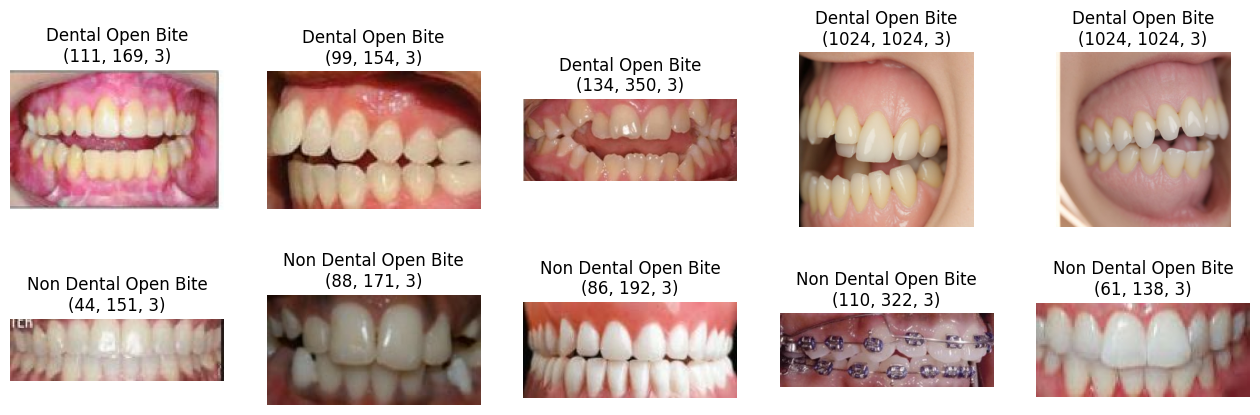

In [8]:
train_folders = ["/kaggle/working/train/Dental Open Bite", "/kaggle/working/train/Non Dental Open Bite"]
plot_class_image(train_folders)

plt.show()


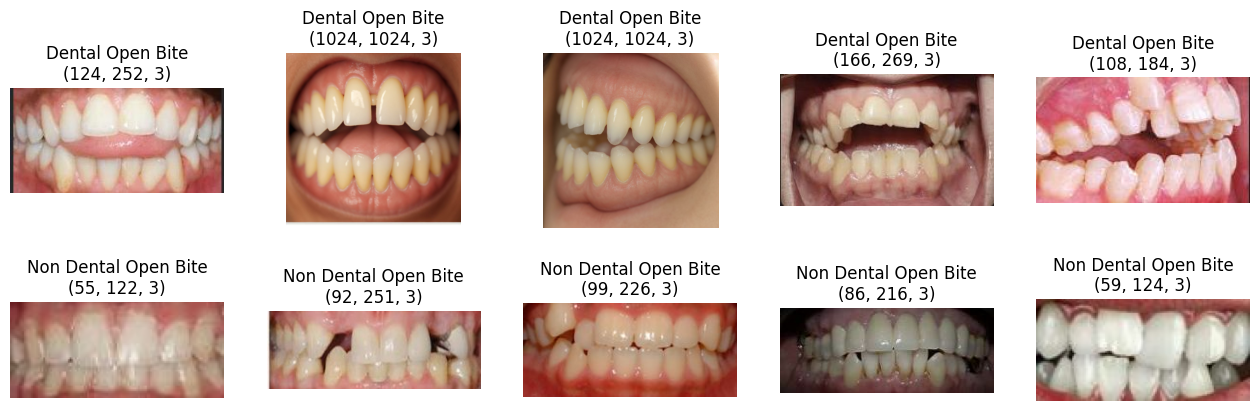

In [9]:
test_folders = ["/kaggle/working/test/Dental Open Bite", "/kaggle/working/test/Non Dental Open Bite"]
plot_class_image(test_folders)

plt.show()

## 4. Image Preprocessing

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
# Rescale
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

In [12]:
train_dir = "/kaggle/working/train"
val_dir = "/kaggle/working/val"
test_dir = "/kaggle/working/test"

In [13]:
# data transfer from directories to batches
train_data = train_datagen.flow_from_directory(directory = train_dir,
                                               batch_size= 32,
                                               target_size= (100,100),
                                               class_mode = "categorical")

Found 801 images belonging to 2 classes.


In [14]:
val_data = valid_datagen.flow_from_directory(directory = val_dir,
                                               batch_size = 32,
                                               target_size = (100,100),
                                               class_mode = "categorical")

Found 100 images belonging to 2 classes.


In [15]:
test_data = test_datagen.flow_from_directory(directory = test_dir,
                                               batch_size = 32,
                                               target_size = (100,100),
                                               class_mode = "categorical")

Found 101 images belonging to 2 classes.


## 5. Model Training

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

from keras.applications import VGG16
from keras import models
from keras import layers
from keras import optimizers
from keras.applications import InceptionV3

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [17]:
def model_result(y_pred, y_val, name):
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    # Calculate ROC AUC
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred)
    
    df = [[precision, recall, f1]]
    
    model_metrics = pd.DataFrame(data = df, columns=['Precision','Recall', 'F1 Score'])
    model_metrics.insert(0, 'Model', name)
    
    return model_metrics, fpr, tpr, roc_auc

### 5.1. Traditional CNN

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.layers import BatchNormalization

In [19]:
tf.keras.backend.clear_session()

In [20]:
model = Sequential()

model.add(Conv2D(128, (3,3), activation='relu', input_shape=(100, 100, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
# Train the model
history = model.fit(train_data, validation_data=val_data, epochs=10)

Epoch 1/10
 4/26 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7396 - loss: 0.6932

I0000 00:00:1711978560.883153     685 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711978560.901182     685 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.6810 - loss: 0.6803

W0000 00:00:1711978564.506883     685 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - accuracy: 0.6787 - loss: 0.6788 - val_accuracy: 0.6500 - val_loss: 0.6327
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.7207 - loss: 0.5180 - val_accuracy: 0.8300 - val_loss: 0.4267
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.8437 - loss: 0.3204 - val_accuracy: 0.8800 - val_loss: 0.2222
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9173 - loss: 0.2267 - val_accuracy: 0.9500 - val_loss: 0.2666
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9052 - loss: 0.2509 - val_accuracy: 0.9400 - val_loss: 0.1126
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9391 - loss: 0.1494 - val_accuracy: 0.8900 - val_loss: 0.2826
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9372 - loss: 0.1381 - val_accuracy: 0.9600 - val_loss: 0.0971
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9760 - loss: 0.0838 - val_accuracy: 0.8900 - val_loss: 

In [22]:
# Predict the labels
predictions = model.predict(test_data)
y_pred = np.argmax(predictions, axis=1)
y_val = test_data.classes

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step 

W0000 00:00:1711978583.672361     687 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step


In [23]:
traditional_cnn_metrics, fpr, tpr, roc_auc = model_result(y_pred, y_val, "Traditional CNN")

traditional_cnn_metrics

,Model,Precision,Recall,F1 Score
0,Traditional CNN,0.626667,0.712121,0.666667


### 5.2. Inception V3

In [25]:
tf.keras.backend.clear_session()

In [26]:
# Load the InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)

# Add a logistic layer with the number of classes in the dataset
predictions = Dense(train_data.num_classes, activation='softmax')(x)

# Define the model
inception_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
inception_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
# Train the model
history = inception_model.fit(train_data, validation_data=val_data, epochs=20)

Epoch 1/20
 2/26 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.5312 - loss: 0.8682  

W0000 00:00:1711978650.340789     687 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


25/26 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7233 - loss: 0.7405

W0000 00:00:1711978686.676861     686 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.7307 - loss: 0.7212 - val_accuracy: 0.6800 - val_loss: 1.9414
Epoch 2/20


W0000 00:00:1711978693.497470     688 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9096 - loss: 0.3113 - val_accuracy: 0.3600 - val_loss: 1.6779
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.9320 - loss: 0.1726 - val_accuracy: 0.3500 - val_loss: 167.0504
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9474 - loss: 0.1578 - val_accuracy: 0.4300 - val_loss: 155.6781
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9660 - loss: 0.1275 - val_accuracy: 0.8800 - val_loss: 1.6724
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.9656 - loss: 0.1844 - val_accuracy: 0.9400 - val_loss: 0.3572
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.9805 - loss: 0.1071 - val_accuracy: 0.7300 - val_loss: 1.6760
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.9343 - loss: 0.2096 - val_accuracy: 0.6100 - val_loss: 2.7142
Epoch 9/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.9802 - loss: 0.1202 - val_accuracy: 0.9100 - val_loss

In [28]:
# Predict the labels
predictions = inception_model.predict(test_data)
y_pred = np.argmax(predictions, axis=1)
y_val = test_data.classes

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

W0000 00:00:1711978743.876033     687 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step


W0000 00:00:1711978753.176415     686 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [29]:
inception_metrics, fpr, tpr, roc_auc = model_result(y_pred, y_val, "Inception V3")

inception_metrics

,Model,Precision,Recall,F1 Score
0,Inception V3,0.626866,0.636364,0.631579


### 5.3. VGG 16

In [31]:
tf.keras.backend.clear_session()

In [32]:
from tensorflow.keras.applications import VGG16

In [33]:
# Load the VGG16 model
base_model = VGG16(include_top=False)

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(256, activation='relu')(x)

# Add a logistic layer with the number of classes in the dataset
predictions = Dense(train_data.num_classes, activation='sigmoid')(x)

# Define the model
vgg_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
vgg_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [34]:
# Train the model
history = vgg_model.fit(train_data, validation_data=val_data, epochs=10)

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 37s 487ms/step - accuracy: 0.5290 - loss: 1.0557 - val_accuracy: 0.6500 - val_loss: 0.5903
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.6496 - loss: 0.7306 - val_accuracy: 0.6500 - val_loss: 0.6693
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.6556 - loss: 0.6440 - val_accuracy: 0.7500 - val_loss: 0.7209
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.8076 - loss: 0.4525 - val_accuracy: 0.9100 - val_loss: 0.2337
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.9316 - loss: 0.2368 - val_accuracy: 0.9000 - val_loss: 0.1913
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.9401 - loss: 0.1989 - val_accuracy: 0.9300 - val_loss: 0.1409
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.9251 - loss: 0.1810 - val_accuracy: 0.9200 - val_loss: 0.2083
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.9418 - loss: 0.1417 - val_accuracy: 0

In [35]:
# Predict the labels
predictions = vgg_model.predict(test_data)
y_pred = np.argmax(predictions, axis=1)
y_val = test_data.classes

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 989ms/step


In [36]:
vgg_metrics, fpr, tpr, roc_auc = model_result(y_pred, y_val, "VGG 16")

vgg_metrics

,Model,Precision,Recall,F1 Score
0,VGG 16,0.630137,0.69697,0.661871


### 6. Models Performance

In [38]:
all_metrics = pd.concat(
    [traditional_cnn_metrics, inception_metrics, vgg_metrics], 
    ignore_index=True, sort=False
)

all_metrics.sort_values(by=['Recall'], ascending=False).style.hide(axis='index')

Model,Precision,Recall,F1 Score
Traditional CNN,0.626667,0.712121,0.666667
VGG 16,0.630137,0.696970,0.661871
Inception V3,0.626866,0.636364,0.631579
